# Metasub data mGPS algorithm - 31/03/2025

Here I am just trying to get the data pre-processing steps right. The idea for doing this is to get the dataset in the right format for easier analysis using neural networks.

## Pre-processing the data

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import datasets
os.chdir("/home/chandru/binp37/")
# Read the metadata for the metasub data.
complete_meta = pd.read_csv("./data/metasub/complete_metadata.csv")
taxa_abund = pd.read_csv("./data/metasub/metasub_taxa_abundance.csv")
taxa_abund = taxa_abund.drop_duplicates(subset=['uuid'])

In [3]:
# Merge the bacterial and metadata
metasub_data = pd.merge(complete_meta,taxa_abund,on='uuid')
metasub_data.shape

(4288, 3711)

In [4]:
# Remove control samples
control_cities = {'control','other_control','neg_control','other','pos_control'}
control_types = {'ctrl cities','negative_control','positive_control'}

mask = metasub_data['city'].isin(control_cities) | metasub_data['control_type'].isin(control_types)
metasub_data = metasub_data[~mask].copy()
metasub_data.shape

(4157, 3711)

In [5]:
#Re-label london boroughs
metasub_data.loc[metasub_data['city'].isin(['kensington','islington']),'city'] = 'london'
metasub_data.shape

(4157, 3711)

In [6]:
# Remove sparse sample locations and doubtful samples
city_counts = metasub_data['city'].value_counts()
small_cities = city_counts[city_counts<8].index.tolist()
remove_samples = metasub_data['city'].isin(['antarctica']+small_cities)
metasub_data = metasub_data[~remove_samples]
metasub_data.shape

(4070, 3711)

In [7]:
# Correct the identified mislabeling of data
kyiv_filter = metasub_data['city'] == 'kyiv'
metasub_data.loc[kyiv_filter,'latitude'] = metasub_data.loc[kyiv_filter,'city_latitude'] # Set all the latitude to the city_latitude
metasub_data.loc[kyiv_filter,'longitude'] = metasub_data.loc[kyiv_filter,'city_longitude'] # Set all the latitude to the city_longitutde

porto_filter = metasub_data['city'] == 'porto'
metasub_data.loc[porto_filter,'city'] = "europe"
metasub_data.shape

(4070, 3711)

In [8]:
# Fill missing latitude and longitude values with city-level data
missing_lat = metasub_data["latitude"].isna()
missing_lon = metasub_data["longitude"].isna()
metasub_data.loc[missing_lat, "latitude"] = metasub_data.loc[missing_lat, "city_latitude"]
metasub_data.loc[missing_lon, "longitude"] = metasub_data.loc[missing_lon, "city_longitude"]
metasub_data.shape

(4070, 3711)

In [9]:
# Correction for incorrect London co-ordinates
london_filter = metasub_data['city'] == 'london'
metasub_data.loc[london_filter,'city_latitude'] = 51.50853
metasub_data.loc[london_filter,'city_longitude'] = -0.12574
metasub_data.shape

(4070, 3711)

In [10]:
metasub_data.iloc[:,:42].columns

Index(['uuid', 'metasub_name', 'core_project', 'project', 'city', 'city_code',
       'latitude', 'longitude', 'surface_material', 'control_type',
       'elevation', 'line', 'station', 'surface', 'temperature', 'traffic',
       'setting', 'num_reads', 'library_post_PCR_Qubit',
       'library_QC_concentration', 'city_latitude', 'city_longitude',
       'coastal_city', 'city_total_population', 'city_population_density',
       'city_land_area_km2', 'city_ave_june_temp_c', 'city_elevation_meters',
       'continent', 'city_koppen_climate', 'barcode', 'ha_id',
       'hudson_alpha_flowcell', 'hudson_alpha_project', 'index_sequence',
       'location_type', 'hudson_alpha_uid', 'other_project_uid',
       'plate_number', 'plate_pos', 'sample_type', 'sl_name'],
      dtype='object')

## Recursive Feature Elimination - 02/04/2025

Here we use RFE as a part of a pipeline to get the best set of parameters for fitting the deep learning model. We need a suitable set of parameters for that are infromative enough to apply a deep learning model. These are called as geographically informative taxa (GITs).

In [ ]:
# Importing libraries
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import multiprocessing
import time
import ray
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold

*Explanation of the Code*

This function is designed to perform feature selection by:

1. **Removing Highly Correlated Features:**
   - Computes a correlation matrix of the features.
   - Identifies features with correlation greater than 0.98 and removes them.

2. **Recursive Feature Elimination (RFE) for Feature Selection:**
   - Uses a Random Forest Classifier to determine feature importance.
   - Applies RFE (Recursive Feature Elimination) to iteratively remove the least important features.
   - The number of features to keep is determined based on predefined subset sizes.

3. **Parallel Processing Support:**  
   Uses multiple CPU cores when specified for efficiency.


In [ ]:
# Feature selection algorithm
def species_select(X,y,remove_correlated=True,subsets=None,cores=1):
    """
    Feature selection algorithm for species classification.

    Parameters:
    X (pd.DataFrame): Feature matrix
    y (pd.Series): Target variable
    remove_correlated (bool): Whether we need to remoce highly correlated variables. (default is set to True)
    subsets (list): List of feature subset sizes to evaluate. If None, it is determined automatically.
    cores (int): Number of CPU cores to use for parallel computation. (default is set to 1)
    
    Returns:
    RFE object: Trained Recursive Feature Elimination (RFE) model.
    """

    start_time = time.time()  # Track execution time

    # Set parallel processing
    num_cores = multiprocessing.cpu_count() if cores > 1 else 1
    print(f"Using {num_cores} CPU cores for computation.")

    if remove_correlated:
        # Compute correlation matrix
        print("Calculating correlation matrix...")
        corr_matrix = X.corr()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Identify correlated features (above 0.98)
        correlated_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.98)]

        # Drop correlated features
        X = X.drop(columns=correlated_features)
        print(f"Correlated feature removed: {len(correlated_features)}")

    # Determine default subset sizes if not provided
    num_features = X.shape[1]
    if subsets is None:
        subsets = [num_features // 2, num_features // 4, num_features // 8, num_features // 16, num_features // 32, num_features // 64]
        subsets = [s for s in subsets  if s > 0] # Remove non-positive values

    print(f"Feature selection subsets: {subsets}")

    # Define model (Random Forrest for fearure ranking)
    model = RandomForestClassifier(n_jobs=num_cores, random_state=123)
    print("Initialized RandomForestClassifier.")

    # Recursive Feature Elimination (RFE)
    for subset in subsets:
        print(f"\nStarting RFE with {subset} features....")
        start_rfe = time.time()
        rfe = RFE(estimator=model, n_features_to_select=min(subsets),step=20)
        # Fit RFE to the data
        rfe.fit(X,y)
        print(f"Completed RFE with {subset} features in {time.time() - start_rfe:.2f} seconds.")

    total_time = time.time() - start_time
    print(f"\nFeature selection completed in {total_time:.2f} seconds.")
    return rfe

featureElim = species_select(X=metasub_data.iloc[:,42:500],
                             y=metasub_data['city'],
                             remove_correlated=False,
                             subsets=[50,100,200,500],
                             cores=12)

### What You Can Do If It's Still Too Slow

1. **Reduce Feature Set Before Running RFE:**
    - If remove_correlated=False, you still have 3711 features.
    - Try using only top 500-1000 features based on variance or importance.

2. **Increase Step Size in RFE:**
    - Default step=1 removes one feature per iteration, which is slow.
    - Try step=5 or step=10 to remove multiple features at once:
    - rfe = RFE(estimatoe=model, n_features_to_select=subset, step=5)
3. **Use XGBoost Instead of Random Forest:**
    - model = XGBClassifier(n_jobs=num_cores, random_state=123)
4. **Sequential Feature Selector:**
    - from sklearn.feature_selection import SequentialFeatureSelector
    sfs = SequentialFeatureSelector(model, n_features_to_select=100, direction='backward', n_jobs=num_cores)
    sfs.fit(X, y)


In [ ]:
def parallel_rfe_feature_selection(X: pd.DataFrame, y: pd.Series, n_jobs: int = 1, random_state: int = 123,
                                   cv: int = 10, subsets: list = None, remove_correlated: bool = True,
                                   correlation_threshold: float = 0.98, num_cpus: int = None):
    """
    Performs parallel Recursive Feature Elimination (RFE) with cross-validation to select the best feature subset.

    Args:
        X (pd.DataFrame): DataFrame of features.
        y (pd.Series): Series of the target variable.
        n_jobs (int): Number of jobs for the base estimator (RandomForestClassifier).
        random_state (int): Random state for reproducibility.
        cv (int): Number of cross-validation folds.
        subsets (list, optional): List of feature subset sizes to evaluate. If None, default subsets are used. Defaults to None.
        remove_correlated (bool, optional): Whether to remove highly correlated features before RFE. Defaults to True.
        correlation_threshold (float, optional): Threshold for identifying highly correlated features. Defaults to 0.98.
        num_cpus (int, optional): Number of CPUs to use for Ray. If None, Ray will auto-detect. Defaults to None.

    Returns:
        tuple: A tuple containing:
            - best_params (dict): Dictionary with the best RFE parameters.
            - best_accuracy (float): The best mean cross-validation accuracy achieved.
            - results_df (pd.DataFrame): DataFrame containing the mean accuracy for each feature subset size.
            - elapsed_time (float): Total time taken for the feature selection process.
    """
    if ray.is_initialized():
        ray.shutdown()
    ray.init(ignore_reinit_error=True, num_cpus=num_cpus)

    model = RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)

    if remove_correlated:
        # Compute correlation matrix
        print("Calculating correlation matrix...")
        corr_matrix = X.corr()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Identify correlated features (above threshold)
        correlated_features = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]

        # Drop correlated features
        X = X.drop(columns=correlated_features)
        print(f"Correlated features removed: {len(correlated_features)}")

    # Determine default subset sizes if not provided
    num_features = X.shape[1]
    if subsets is None:
        subsets = [num_features // 2, num_features // 4, num_features // 8, num_features // 16, num_features // 32, num_features // 64]
        subsets = [s for s in subsets if s > 0]  # Remove non-positive values

    n_features_options = sorted(list(set(subsets))) # Ensure unique and sorted subset sizes
    total_iterations = len(n_features_options) * cv

    print(f"\nStarting RFE with subsets of features: {n_features_options}")

    # Define remote function for parallel execution
    @ray.remote
    def evaluate_rfe_remote(n_features, fold, X_remote, y_remote):
        """Performs RFE feature selection and evaluates performance for a given fold."""
        pipe = make_pipeline(RFE(estimator=model, n_features_to_select=n_features, step=10))

        # We use the stratified K fold to split the data into training and validation sets
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=fold)
        train_index, test_index = list(skf.split(X_remote, y_remote))[fold]

        # train_index and test_index contain the index values for extracting training and testing data
        X_train = X_remote.iloc[train_index, :]
        X_test = X_remote.iloc[test_index, :]
        y_train = y_remote.iloc[train_index]
        y_test = y_remote.iloc[test_index]

        # Fit the model using the training data and then evaluate the score based on the testing data
        pipe.fit(X_train, y_train)
        score = pipe.score(X_test, y_test)

        return n_features, fold, score

    start_time = time.time()
    X_ray = ray.put(X)
    y_ray = ray.put(y)
    tasks = [evaluate_rfe_remote.remote(n_features, fold, X_ray, y_ray)
             for n_features in n_features_options for fold in range(cv)]

    results = []
    with tqdm(total=total_iterations, desc='Parallel RFE + Cross-validation') as pbar:
        while tasks:
            done, tasks = ray.wait(tasks, num_returns=1)
            result = ray.get(done[0])
            results.append((result[0], result[2]))  # (n_features, score)
            pbar.update(1)

    # Aggregate mean accuracy for each feature subset
    results_df = pd.DataFrame(results, columns=["n_features", "accuracy"])
    results_df = results_df.groupby("n_features").mean().reset_index()

    # Find best feature subset
    best_row = results_df.loc[results_df["accuracy"].idxmax()]
    best_n_features = int(best_row["n_features"])
    best_accuracy = best_row["accuracy"]

    end_time = time.time()
    elapsed_time = end_time - start_time

    best_params = {"rfe__n_features_to_select": best_n_features}

    ray.shutdown()

    return best_params, best_accuracy, results_df, elapsed_time

X = metasub_data.iloc[:,42:400]
y= metasub_data['city']

best_parameters, best_score, all_results, time_taken = parallel_rfe_feature_selection(
        X=X,
        y=y,
        n_jobs=-1,  # Use all available cores for RandomForest within each Ray task
        random_state=123,
        cv=5,
        subsets=[50, 100, 200, 300, 500],
        remove_correlated=True,
        correlation_threshold=0.95,
        num_cpus=50  # Limit Ray to 4 CPUs for this example
    )

print(f'\nBest params: {best_parameters}')
print(f'Best accuracy: {best_score:.6f}')
print(f'Mean accuracy for all tested feature subsets:\n{all_results}')
print(f'Total time taken: {time_taken:.2f} seconds')

In [ ]:
# Since I have lost the model, but I know that 200 features gives the best accuracy of 0.89. 
X = metasub_data.iloc[:,42:]
y = metasub_data['city']
model_200 = RandomForestClassifier(n_jobs=24,random_state=123)
rfe = RFE(estimator=model_200,n_features_to_select=200,step=20)
rfe.fit(X,y)

selected_features = X.columns[rfe.support_]
print(selected_features)

print(len(rfe.support_))
# All the accuracy results from the previous runs
#results_df = pd.DataFrame(results,columns=['n_vars','accuracy'])
#results_df.to_csv('mgps_git_taxa.csv')

## Initial Neural Networks Tests - 03/04/2025

In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

### Data Preparation

In [ ]:
nn_data = pd.concat([metasub_data[selected_features],metasub_data[['continent','city','latitude','longitude']]],axis=1)
nn_data.to_csv('./results/metasub_training_testing_data.csv',index=False)
nn_data.head()

#### Convert the city and continent names into vectors

In [ ]:
print(f"The unique cities in the metasub dataset are {len(list(nn_data['city'].unique()))}.")
print(f"The unique continents in the metasub dataset are {list(nn_data['continent'].unique())}")

In [ ]:
# Initialize label and scalers
le_continent = LabelEncoder()
le_city = LabelEncoder()
stdscaler_lat = StandardScaler() # I can try MinMaxScaler as well
stdscaler_long = StandardScaler()
# Convert all the categorical variables into numbers
nn_data['city_encoding'] = nn_data[['city']].apply(le_city.fit_transform)
nn_data['continent_encoding'] = nn_data[['continent']].apply(le_continent.fit_transform)
nn_data['lat_scaled'] = stdscaler_lat.fit_transform(nn_data[['latitude']])
nn_data['long_scaled'] = stdscaler_long.fit_transform(nn_data[['longitude']])
# Store all the new scaled and encoded data in a new dataframe
encoded_nn_data = nn_data.drop(columns=['city','continent','latitude','longitude'],axis=1)
#encoded_nn_data = nn_data.copy()
encoded_nn_data.head()

### Splitting the dataset - Cross Validation

In [ ]:
# KFold - Shuffle=True, I will do this later. For now, I will just use the train_test_split.
kf = KFold(n_splits=5,shuffle=True, random_state=123)

X = encoded_nn_data.iloc[:,:200].values
y = encoded_nn_data[['continent_encoding','city_encoding','lat_scaled','long_scaled']].values 

for train_idx, val_idx in kf.split(X,y[:,1]): # We will use only the city column to create the split. Based on the ordering of the columns in the previous cell.
    X_train = pd.DataFrame(X[train_idx])
    y_train = pd.DataFrame(y[train_idx])

    X_test = pd.DataFrame(X[val_idx])
    y_test = pd.DataFrame(y[val_idx])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

### Neural Network 

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_nn_data.iloc[:,:200].values,
                                                    encoded_nn_data[['continent_encoding','city_encoding','lat_scaled','long_scaled']].values,
                                                    test_size=0.2,
                                                    random_state=123)

In [ ]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self,df,target):
        self.df = df.astype(np.float32)
        self.target = target
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self,idx):
        dp = self.df[idx]
        targ = self.target[idx]
        dp = torch.from_numpy(dp)
        continent_city = torch.tensor(targ[0:2],dtype=torch.long)
        lat_lon = torch.tensor(targ[2:],dtype=torch.float32)
        targ_combined = torch.cat((continent_city,lat_lon)) 
        return dp,continent_city, lat_lon

In [ ]:
CustDat(X_train,y_train).__getitem__(23)[1:]

In [ ]:
train_dl = torch.utils.data.DataLoader(CustDat(X_train,y_train),
                                       batch_size=64,shuffle=True,num_workers=4,pin_memory=False)

test_dl = torch.utils.data.DataLoader(CustDat(X_test,y_test),
                                       batch_size=64,shuffle=True,num_workers=4,pin_memory=False)

#### First Model - 07/04/2025

In [ ]:
# Writing the class for the netural network continent, citites and latitude and longitutude
# This is one architechture that I have  created a sequential architecture where the prediction of each level (continent -> city -> latitude -> longitude) depends on the output of the previous level. 
# The initial features are progressively enriched with the predictions from the preceding models to make the subsequent predictions. 
# Each individual model is a feedforward neural network with a consistent structure of three hidden layers with ReLU activations. 
# The output layer's size and the choice of activation (or lack thereof) depend on whether the task is classification (continent, city) or regression (latitude, longitude).

class NeuralNetContinent(nn.Module):
    def __init__(self, input_size_continents, num_continents):
        # Initializes the NeuralNetContinent class, inheriting from nn.Module (PyTorch's base class for neural network modules).
        super(NeuralNetContinent, self).__init__()
        # Defines the first linear layer: input size is 'input_size_continents' (assumed to be 200, representing the number of initial features),
        # and the output size is 400 (the number of neurons in this layer). This layer performs a linear transformation on the input data.
        self.layer1 = nn.Linear(input_size_continents, 400) # 200 GITs
        # Defines the second linear layer: input size is 400 (output of the previous layer), and the output size is also 400.
        self.layer2 = nn.Linear(400, 400)
        # Defines the third linear layer: input size is 400, and the output size is 200.
        self.layer3 = nn.Linear(400, 200)
        # Defines the final linear layer: input size is 200, and the output size is 'num_continents' (assumed to be 7, representing the number of continent classes).
        # The output of this layer will represent the raw scores (logits) for each continent.
        self.layer4 = nn.Linear(200, num_continents) # 7 continents
        # Initializes the ReLU (Rectified Linear Unit) activation function. ReLU introduces non-linearity to the network, allowing it to learn complex patterns.
        self.relu = nn.ReLU()

    def forward(self, x):
        # Defines the forward pass of the neural network. 'x' is the input tensor.

        # The input 'x' is passed through the first linear layer, and then the ReLU activation function is applied element-wise to the output.
        out = self.relu(self.layer1(x))
        # The output of the first activation is passed through the second linear layer, followed by ReLU.
        out = self.relu(self.layer2(out))
        # The output of the second activation is passed through the third linear layer, followed by ReLU.
        out = self.relu(self.layer3(out))
        # The output of the third activation is passed through the final linear layer. No activation function is typically applied here for classification tasks,
        # as the raw scores (logits) are used by the CrossEntropyLoss.
        out = self.layer4(out)

        # Returns the output tensor, which contains the raw scores for each continent class.
        return out

class NeuralNetCities(nn.Module):
    def __init__(self, input_size_cities, num_cities):
        # Initializes the NeuralNetCities class, inheriting from nn.Module.
        super(NeuralNetCities, self).__init__()
        # Defines the first linear layer: input size is 'input_size_cities' (assumed to be 207, including initial features and continent probabilities),
        # and the output size is 400.
        self.layer1 = nn.Linear(input_size_cities, 400) # 207 (continent probabilities also included)
        # Defines the second linear layer: input size is 400, and the output size is also 400.
        self.layer2 = nn.Linear(400, 400)
        # Defines the third linear layer: input size is 400, and the output size is 200.
        self.layer3 = nn.Linear(400, 200)
        # Defines the final linear layer: input size is 200, and the output size is 'num_cities' (assumed to be 40, representing the number of city classes).
        # The output of this layer will represent the raw scores (logits) for each city.
        self.layer4 = nn.Linear(200, num_cities) # 40 continents
        # Initializes the ReLU activation function.
        self.relu = nn.ReLU()

    def forward(self, x):
        # Defines the forward pass of the cities neural network. 'x' is the input tensor.

        # The input 'x' is passed through the first linear layer, followed by ReLU.
        out = self.relu(self.layer1(x))
        # The output of the first activation is passed through the second linear layer, followed by ReLU.
        out = self.relu(self.layer2(out))
        # The output of the second activation is passed through the third linear layer, followed by ReLU.
        out = self.relu(self.layer3(out))
        # The output of the third activation is passed through the final linear layer (no activation for logits).
        out = self.layer4(out)

        # Returns the output tensor, containing raw scores for each city class.
        return out

class NeuralNetLat(nn.Module):
    def __init__(self, input_size_lat, lat_size):
        # Initializes the NeuralNetLat class for latitude prediction, inheriting from nn.Module.
        super(NeuralNetLat, self).__init__()
        # Defines the first linear layer: input size is 'input_size_lat' (assumed to be 247, including initial features, continent probabilities, and city probabilities),
        # and the output size is 400.
        self.layer1 = nn.Linear(input_size_lat, 400) # 247 input shape (continent and cities probabilities also included)
        # Defines the second linear layer: input size is 400, and the output size is also 400.
        self.layer2 = nn.Linear(400, 400)
        # Defines the third linear layer: input size is 400, and the output size is 200.
        self.layer3 = nn.Linear(400, 200)
        # Defines the final linear layer: input size is 200, and the output size is 'lat_size' (set to 1, for predicting a single latitude value).
        # For regression tasks like predicting a single numerical value, no activation function is typically applied to the final layer.
        self.layer4 = nn.Linear(200, lat_size)
        # Initializes the ReLU activation function for the hidden layers.
        self.relu = nn.ReLU()

    def forward(self, x):
        # Defines the forward pass for the latitude prediction network.

        # Input 'x' through the first linear layer and ReLU.
        out = self.relu(self.layer1(x))
        # Output of the first activation through the second linear layer and ReLU.
        out = self.relu(self.layer2(out))
        # Output of the second activation through the third linear layer and ReLU.
        out = self.relu(self.layer3(out))
        # Output of the third activation through the final linear layer (no activation for regression output).
        out = self.layer4(out)

        # Returns the predicted latitude value.
        return out

class NeuralNetLong(nn.Module):
    def __init__(self, input_size_long, long_size):
        # Initializes the NeuralNetLong class for longitude prediction, inheriting from nn.Module.
        super(NeuralNetLong, self).__init__()
        # Defines the first linear layer: input size is 'input_size_long' (assumed to be 248, including initial features, continent probabilities, city probabilities, and the latitude value),
        # and the output size is 400.
        self.layer1 = nn.Linear(input_size_long, 400) # 248 input shape (continent, cities probabilites and the latitude values as well)
        # Defines the second linear layer: input size is 400, and the output size is also 400.
        self.layer2 = nn.Linear(400, 400)
        # Defines the third linear layer: input size is 400, and the output size is 200.
        self.layer3 = nn.Linear(400, 200)
        # Defines the final linear layer: input size is 200, and the output size is 'long_size' (set to 1, for predicting a single longitude value).
        # Similar to latitude, no activation is typically used on the final layer for regression.
        self.layer4 = nn.Linear(200, long_size)
        # Initializes the ReLU activation function for the hidden layers.
        self.relu = nn.ReLU()

    def forward(self, x):
        # Defines the forward pass for the longitude prediction network.

        # Input 'x' through the first linear layer and ReLU.
        out = self.relu(self.layer1(x))
        # Output of the first activation through the second linear layer and ReLU.
        out = self.relu(self.layer2(out))
        # Output of the second activation through the third linear layer and ReLU.
        out = self.relu(self.layer3(out))
        # Output of the third activation through the final linear layer (no activation for regression output).
        out = self.layer4(out)

        # Returns the predicted longitude value.
        return out


# Hyperparameters
# Defines the size of the input features for the continent prediction model.
input_size_continents = 200
# Defines the size of the input features for the city prediction model (original features + continent probabilities).
input_size_cities = 207
# Defines the size of the input features for the latitude prediction model (original features + continent probabilities + city probabilities).
input_size_lat = 247
# Defines the size of the input features for the longitude prediction model (original features + continent probabilities + city probabilities + latitude).
input_size_long = 248

# Defines the number of continent classes.
num_continents = 7
# Defines the number of city classes.
num_cities = 40
# Defines the output size for latitude prediction (a single value).
lat_size = 1
# Defines the output size for longitude prediction (a single value).
long_size = 1

# Defines the learning rate for the optimizers, controlling the step size during weight updates.
learning_rate = 0.001
# Defines the batch size for training, the number of samples processed in one iteration.
batch_size = 64
# Defines the number of training epochs, the number of times the entire training dataset is passed through the network.
num_epochs = 20

# Initialize the neural network models and move them to the specified device (CPU or GPU).
nn_continent_model = NeuralNetContinent(input_size_continents=input_size_continents, num_continents=num_continents).to(device)
nn_cities_model = NeuralNetCities(input_size_cities=input_size_cities, num_cities=num_cities).to(device)
nn_lat_model = NeuralNetLat(input_size_lat=input_size_lat, lat_size=lat_size).to(device)
nn_long_model = NeuralNetLong(input_size_long=input_size_long, long_size=long_size).to(device)


# Define the loss functions. CrossEntropyLoss is used for multi-class classification (continents and cities),
# and MSELoss (Mean Squared Error Loss) is used for regression (latitude and longitude).
criterion = nn.CrossEntropyLoss()
criterion_lat_lon = nn.MSELoss()
# Define the optimizers for each model. Adam is used for continent and city classification,
# and SGD (Stochastic Gradient Descent) is used for latitude and longitude regression.
optimizer_continent = torch.optim.Adam(nn_continent_model.parameters(), lr=learning_rate)
optimizer_cities = torch.optim.Adam(nn_cities_model.parameters(), lr=learning_rate)
optimizer_lat = torch.optim.SGD(nn_lat_model.parameters(), lr=learning_rate)
optimizer_long = torch.optim.SGD(nn_long_model.parameters(), lr=learning_rate)

In [ ]:
start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time() # start time of each epoch

    for batch_idx, (data,continent_city,lat_long) in enumerate(train_dl):
        data = data.to(device=device)


        # scores continent
        scores_continent = nn_continent_model(data)
        in_data_cities = torch.cat((data,scores_continent),1)

        # scores cities
        scores_cities = nn_cities_model(in_data_cities)
        in_data_lat = torch.cat((in_data_cities,scores_cities),1)
        
        # scores latititude
        scores_lat = nn_lat_model(in_data_lat)
        in_data_long = torch.cat((in_data_lat,scores_lat),1)

        # scores longitude
        scores_long = nn_long_model(in_data_long)
 

        # loss
        loss_cities = criterion(scores_cities, continent_city[:,1])
        loss_continents = criterion(scores_continent,continent_city[:,0])
        loss_lat = criterion_lat_lon(scores_lat,lat_long[:,0].unsqueeze(1))
        loss_long = criterion_lat_lon(scores_long,lat_long[:,-1].unsqueeze(1))

        # backward propogation
        optimizer_cities.zero_grad()
        optimizer_continent.zero_grad()
        optimizer_lat.zero_grad()
        optimizer_long.zero_grad()
        
        loss_long.backward(retain_graph=True)
        loss_lat.backward(retain_graph=True)
        loss_cities.backward(retain_graph=True)
        loss_continents.backward()


        # gradient descent
        optimizer_cities.step()
        optimizer_continent.step()
    

    epoch_end_time = time.time() # end time of each epoch
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"\nEpoch {epoch+1}/{num_epochs}, Loss Continents: {loss_continents.item():.4f}, Epoch Time: {epoch_duration:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss Cities: {loss_cities.item():.4f}, Epoch Time: {epoch_duration:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss Latitudes: {loss_lat.item():.4f}, Epoch Time: {epoch_duration:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss Longitudes: {loss_long.item():.4f}, Epoch Time: {epoch_duration:.2f} seconds")


In [ ]:
# Check accuracy on different levels
def check_accuracy(loader, continent_model, cities_model=None, lat_model=None, long_model=None, tolerance_lat=0.1, tolerance_long=0.1):
    num_correct_continent = 0
    num_samples = 0
    num_correct_cities = 0
    total_absolute_error_lat = 0.0
    total_absolute_error_long = 0.0

    continent_model.eval()
    if cities_model:
        cities_model.eval()
    if lat_model:
        lat_model.eval()
    if long_model:
        long_model.eval()

    with torch.no_grad():
        for (data, continent_city, lat_long) in loader:
            data = data.to(device=device)
            target_continent = continent_city[:, 0].to(device=device)
            target_cities = continent_city[:, 1].to(device=device)
            target_lat = lat_long[:, 0].to(device=device).unsqueeze(1) # Ensure correct shape for comparison
            target_long = lat_long[:, 1].to(device=device).unsqueeze(1) # Ensure correct shape for comparison

            # Continent predictions
            scores_continent = continent_model(data)
            _, predictions_continent = scores_continent.max(1)
            num_correct_continent += (predictions_continent == target_continent).sum()

            num_samples += predictions_continent.size(0)

            # Cities predictions (if cities model is provided)
            if cities_model:
                scores_continent_for_cities = continent_model(data) # Get continent scores again
                in_data_cities = torch.cat((data, scores_continent_for_cities), 1)
                scores_cities = cities_model(in_data_cities)
                _, predictions_cities = scores_cities.max(1)
                num_correct_cities += (predictions_cities == target_cities).sum()

            # Latitude predictions (if latitude model is provided)
            if lat_model:
                scores_continent_for_lat = continent_model(data)
                in_data_cities_for_lat = torch.cat((data, scores_continent_for_lat), 1)
                scores_cities_for_lat = cities_model(in_data_cities_for_lat)
                in_data_lat = torch.cat((in_data_cities_for_lat, scores_cities_for_lat), 1)
                predicted_lat = lat_model(in_data_lat)
                absolute_error_lat = torch.abs(predicted_lat - target_lat)
                total_absolute_error_lat += torch.sum(absolute_error_lat).item()

            # Longitude predictions (if longitude model is provided)
            if long_model:
                scores_continent_for_long = continent_model(data)
                scores_cities_for_long = cities_model(torch.cat((data, scores_continent_for_long), 1))
                in_data_lat_for_long = torch.cat((torch.cat((data, scores_continent_for_long), 1), scores_cities_for_long), 1)
                predicted_lat_for_long = lat_model(in_data_lat_for_long)
                in_data_long = torch.cat((in_data_lat_for_long, predicted_lat_for_long), 1)
                predicted_long = long_model(in_data_long)
                absolute_error_long = torch.abs(predicted_long - target_long)
                total_absolute_error_long += torch.sum(absolute_error_long).item()



    accuracy_continent = float(num_correct_continent) / float(num_samples) * 100
    print(f'Continent Model Accuracy: {accuracy_continent:.2f}%')

    if cities_model:
        accuracy_cities = float(num_correct_cities) / float(num_samples) * 100
        print(f'Cities Model Accuracy: {accuracy_cities:.2f}%')

    if lat_model:
        mean_absolute_error_lat = total_absolute_error_lat / num_samples
        print(f'Latitude Model Mean Absolute Error: {mean_absolute_error_lat:.4f}')

    if long_model:
        mean_absolute_error_long = total_absolute_error_long / num_samples
        print(f'Longitude Model Mean Absolute Error: {mean_absolute_error_long:.4f}')

    continent_model.train()
    if cities_model:
        cities_model.train()
    if lat_model:
        lat_model.train()
    if long_model:
        long_model.train()

# Check accuracy for all models
print("\nTraining Accuracy:")
check_accuracy(train_dl, nn_continent_model, nn_cities_model, nn_lat_model, nn_long_model)
print("\nTest Accuracy:")
check_accuracy(test_dl, nn_continent_model, nn_cities_model, nn_lat_model, nn_long_model)

### Second Model - 07/04/2025

In [ ]:
class CombinedNeuralNet(nn.Module):
    def __init__(self,input_size):
        super(CombinedNeuralNet,self).__init__()
        # Initial layers shared by all the tasks
        self.layer1 = nn.Linear(input_size,400)
        self.layer2 = nn.Linear(400,400)
        self.layer3 = nn.Linear(400,200)
        self.relu = nn.ReLU()

        # Branch for Continent Prediction
        self.continent_layer = nn.Linear(200,7) # Output for 7 continents
        
        # Layers after continent branch
        self.layer_after_continent = nn.Linear(207,400) # Concatenate previous layers
        self.layer_cities1 = nn.Linear(400,400)
        self.layer_cities2 = nn.Linear(400,200) 
        self.city_layer = nn.Linear(200, 40) # Output for 40 cities

        # Layers after city branch
        self.layer_after_cities = nn.Linear(247,400)  # Concatenate previous layers
        self.layer_lat1 = nn.Linear(400,400)
        self.layer_lat2 = nn.Linear(400,200)
        self.latitude_layer = nn.Linear(200,1) # Ouput for latitude

        # Layers after latitude branch
        self.layer_after_lat = nn.Linear(248, 400) # Concatenate previous layers
        self.layer_long1 = nn.Linear(400,400)
        self.layer_long2 = nn.Linear(400,200)
        self.longitude_layer = nn.Linear(200,1) # Outptu for longitude

    def forward(self,x):
        
        # Shared layers
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        shared_out = self.relu(self.layer3(out))

        # Continent branch
        continent_logits = self.continent_layer(shared_out)

        # City branch
        concat_continent = torch.cat((shared_out, continent_logits), dim=1)
        out_cities = self.relu(self.layer_after_continent(concat_continent))
        out_cities = self.relu(self.layer_cities1(out_cities))
        out_cities = self.relu(self.layer_cities2(out_cities))
        city_logits = self.city_layer(out_cities)

        # Latitude branch
        concat_cities = torch.cat((concat_continent, city_logits), dim=1) # Include continent info as well
        out_lat = self.relu(self.layer_after_cities(concat_cities))
        out_lat = self.relu(self.layer_lat1(out_lat))
        out_lat = self.relu(self.layer_lat2(out_lat))
        latitude_prediction = self.latitude_layer(out_lat)

        # Longitude branch
        concat_lat = torch.cat((concat_cities, latitude_prediction), dim=1) # Include continent and city info
        out_long = self.relu(self.layer_after_lat(concat_lat))
        out_long = self.relu(self.layer_long1(out_long))
        out_long = self.relu(self.layer_long2(out_long))
        longitude_prediction = self.longitude_layer(out_long)

        return continent_logits, city_logits, latitude_prediction, longitude_prediction


# Hyperparameters
input_size = 200
learning_rate = 0.001
batch_size = 64
num_epochs = 20

# Initialize the combined network
combined_model = CombinedNeuralNet(input_size).to(device)

# Loss functions and optimizers
criterion_continent = nn.CrossEntropyLoss()
criterion_cities = nn.CrossEntropyLoss()
criterion_lat_lon = nn.MSELoss()
optimizer_combined = torch.optim.Adam(combined_model.parameters(), lr=learning_rate)

In [ ]:
# Training loop (example - you'll need to adapt your existing loop)
start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()

    for batch_idx, (data, continent_city, lat_long) in enumerate(train_dl):
        data = data.to(device)
        target_continent = continent_city[:, 0].to(device)
        target_cities = continent_city[:, 1].to(device)
        target_lat = lat_long[:, 0].unsqueeze(1).to(device)
        target_long = lat_long[:, 1].unsqueeze(1).to(device)

        # Forward pass
        continent_logits, city_logits, latitude_prediction, longitude_prediction = combined_model(data)

        # Calculate losses
        loss_continent = criterion_continent(continent_logits, target_continent)
        loss_cities = criterion_cities(city_logits, target_cities)
        loss_lat = criterion_lat_lon(latitude_prediction, target_lat)
        loss_long = criterion_lat_lon(longitude_prediction, target_long)
        total_loss = loss_continent + loss_cities + loss_lat + loss_long

        # Backward pass and optimization
        optimizer_combined.zero_grad()
        total_loss.backward()
        optimizer_combined.step()

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss (Continent): {loss_continent.item():.4f}, Loss (Cities): {loss_cities.item():.4f}, Loss (Lat): {loss_lat.item():.4f}, Loss (Long): {loss_long.item():.4f}, Epoch Time: {epoch_duration:.2f} seconds")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total Training Time: {total_duration:.2f} seconds")

In [ ]:
# Modified check_accuracy function for the combined model
def check_combined_accuracy(loader, model):
    num_correct_continent = 0
    num_samples = 0
    num_correct_cities = 0
    total_absolute_error_lat = 0.0
    total_absolute_error_long = 0.0

    model.eval()
    with torch.no_grad():
        for (data, continent_city, lat_long) in loader:
            data = data.to(device)
            target_continent = continent_city[:, 0].to(device)
            target_cities = continent_city[:, 1].to(device)
            target_lat = lat_long[:, 0].unsqueeze(1).to(device)
            target_long = lat_long[:, 1].unsqueeze(1).to(device)

            continent_logits, city_logits, latitude_prediction, longitude_prediction = model(data)

            # Continent Accuracy
            _, predictions_continent = continent_logits.max(1)
            num_correct_continent += (predictions_continent == target_continent).sum()
            num_samples += predictions_continent.size(0)

            # Cities Accuracy
            _, predictions_cities = city_logits.max(1)
            num_correct_cities += (predictions_cities == target_cities).sum()

            # Latitude Error
            absolute_error_lat = torch.abs(latitude_prediction - target_lat)
            total_absolute_error_lat += torch.sum(absolute_error_lat).item()

            # Longitude Error
            absolute_error_long = torch.abs(longitude_prediction - target_long)
            total_absolute_error_long += torch.sum(absolute_error_long).item()

    accuracy_continent = float(num_correct_continent) / float(num_samples) * 100
    accuracy_cities = float(num_correct_cities) / float(num_samples) * 100
    mean_absolute_error_lat = total_absolute_error_lat / num_samples
    mean_absolute_error_long = total_absolute_error_long / num_samples

    print(f'Combined Model - Continent Accuracy: {accuracy_continent:.2f}%')
    print(f'Combined Model - Cities Accuracy: {accuracy_cities:.2f}%')
    print(f'Combined Model - Latitude Mean Absolute Error: {mean_absolute_error_lat:.4f}')
    print(f'Combined Model - Longitude Mean Absolute Error: {mean_absolute_error_long:.4f}')

    model.train()

# Check accuracy of the combined model
print("\nTraining Accuracy (Combined Model):")
check_combined_accuracy(train_dl, combined_model)
print("\nTest Accuracy (Combined Model):")
check_combined_accuracy(test_dl, combined_model)

#### Visualize the results

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
continent_encoding_map = dict(zip(le_continent.transform(le_continent.classes_), le_continent.classes_))
city_encoding_map = dict(zip(le_city.transform(le_city.classes_),le_city.classes_))

In [ ]:
combined_model.eval()
all_predictions_continents = []
all_predictions_cities = []
all_labels_continents = []
all_labels_cities = []

with torch.no_grad():
    for data, continent_city, lat_long in train_dl:
        data = data.to(device)
        target_continent = continent_city[:, 0].to(device)
        target_cities = continent_city[:, 1].to(device)
        target_lat = lat_long[:, 0].unsqueeze(1).to(device)
        target_long = lat_long[:, 1].unsqueeze(1).to(device)

        continent_logits, city_logits, latitude_prediction, longitude_prediction = combined_model(data)
        _, predicted_continents = torch.max(continent_logits,1)
        _, predicted_cities = torch.max(city_logits,1)
        all_predictions_continents.extend(predicted_continents.detach().cpu().numpy())
        all_labels_continents.extend(target_continent.detach().cpu().numpy())
        all_predictions_cities.extend(predicted_cities.detach().cpu().numpy())
        all_labels_cities.extend(target_cities.detach().cpu().numpy())

cm = confusion_matrix(all_labels_continents,all_predictions_continents)
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(len(continent_encoding_map), len(continent_encoding_map)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(continent_encoding_map.values()), yticklabels=list(continent_encoding_map.values()))
plt.xlabel('Predicted Continent')
plt.ylabel('True Continent')
plt.title('Confusion Matrix for Continent Predictions')
plt.show()


combined_model.train()

In [ ]:
true_lat = stdscaler_lat.inverse_transform(target_lat.detach().cpu().numpy())
true_long = stdscaler_long.inverse_transform(target_long.detach().cpu().numpy())

predicted_lat = stdscaler_lat.inverse_transform(latitude_prediction.detach().cpu().numpy())
predicted_long = stdscaler_lat.inverse_transform(longitude_prediction.detach().cpu().numpy())

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(true_long, true_lat, label='True Locations', s=20, alpha=0.7)
plt.scatter(predicted_long, predicted_lat, label='Predicted Locations', s=20, alpha=0.7, marker='x')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('True vs. Predicted Locations')
plt.legend()
plt.grid(True)
plt.show()

# Taxonomic analysis

In [ ]:
# Don't run this as of now
from Bio import Entrez

def get_ncbi_lineage(species_list, email="your.email@example.com", api_key=None, delay_seconds=0.35):
    """
    Retrieves the full taxonomic lineage from NCBI for a list of species names.

    Args:
        species_list (list): A list of species names (e.g., ['Escherichia coli', 'Bacillus subtilis']).
        email (str): Your email address, required by NCBI.
        api_key (str, optional): Your NCBI API key. Improves request limits. Defaults to None.
        delay_seconds (float): Delay between requests to adhere to NCBI's usage policy.
                               Default is 0.35 seconds (for 3 requests/sec without API key).
                               Set to 0.1 for API key.

    Returns:
        dict: A dictionary where keys are species names and values are their taxonomic lineages
              as lists of strings (e.g., ['Bacteria', 'Proteobacteria', ...]).
              Returns an empty list for lineage if a species is not found.
    """
    Entrez.email = email
    if api_key:
        Entrez.api_key = api_key
        delay_seconds = 0.1 # Increase rate limit to 10 requests/sec

    lineages = {}
    found_species = set()
    not_found_species = []

    print(f"Starting lineage retrieval for {len(species_list)} species...")

    for i, species_name in enumerate(species_list):
        if i > 0: # Add delay between requests
            time.sleep(delay_seconds)

        print(f"Processing species {i+1}/{len(species_list)}: {species_name}")

        try:
            # 1. Search for the species name in the Taxonomy database to get its Tax ID
            handle = Entrez.esearch(db="taxonomy", term=species_name, retmode="xml")
            record = Entrez.read(handle)
            handle.close()

            tax_ids = record["IdList"]

            if not tax_ids:
                print(f"  Warning: No Tax ID found for '{species_name}'. Skipping.")
                lineages[species_name] = []
                not_found_species.append(species_name)
                continue

            # Take the first Tax ID if multiple are returned (usually the most relevant)
            tax_id = tax_ids[0]

            # 2. Fetch the taxonomy record using the Tax ID
            handle = Entrez.efetch(db="taxonomy", id=tax_id, retmode="xml")
            tax_record = Entrez.read(handle)
            handle.close()

            # The lineage information is typically in the 'Lineage' field
            if tax_record and tax_record[0] and 'Lineage' in tax_record[0]:
                lineage_str = tax_record[0]['Lineage']
                # Split the lineage string into a list of ranks
                # NCBI lineage is usually semicolon-separated
                lineage_list = [rank.strip() for rank in lineage_str.split(';') if rank.strip()]
                lineages[species_name] = lineage_list
                found_species.add(species_name)
                print(f"  Lineage found: {'; '.join(lineage_list)}")
            else:
                print(f"  Warning: Lineage not found for '{species_name}' (Tax ID: {tax_id}). Skipping.")
                lineages[species_name] = []
                not_found_species.append(species_name)

        except Exception as e:
            print(f"  Error retrieving lineage for '{species_name}': {e}")
            lineages[species_name] = []
            not_found_species.append(species_name)

    print("\n--- Summary ---")
    print(f"Successfully retrieved lineage for {len(found_species)} species.")
    if not_found_species:
        print(f"Could not find lineage for {len(not_found_species)} species:")
        for sp in not_found_species:
            print(f"  - {sp}")

    return lineages

if __name__ == "__main__":
    # Your list of species
    species_to_query = metasub_data.iloc[:,42:].columns

    # --- Configuration ---
    # IMPORTANT: Replace with your actual email and (optionally) API key
    my_email = "1ms19bt011@gmail.com" # Replace with your email
    my_api_key = None  # Replace with your API key, or set to None

    # Get lineages
    species_lineages = get_ncbi_lineage(
        species_to_query,
        email=my_email,
        api_key=my_api_key
    )

    # Convert to DataFrame for easier manipulation and saving
    lineage_df = pd.DataFrame.from_dict(species_lineages, orient='index')
    lineage_df.index.name = 'Species'
    # Give generic column names for lineage ranks
    lineage_df.columns = [f'Rank_{i+1}' for i in range(lineage_df.shape[1])]

    # Save to CSV
    output_filename = "species_lineages.csv"
    lineage_df.to_csv(output_filename)
    print(f"\nLineage data saved to {output_filename}")

    # Example: Display first few entries of the DataFrame
    print("\nFirst 5 entries of the lineage DataFrame:")
    print(lineage_df.head())

<Axes: >

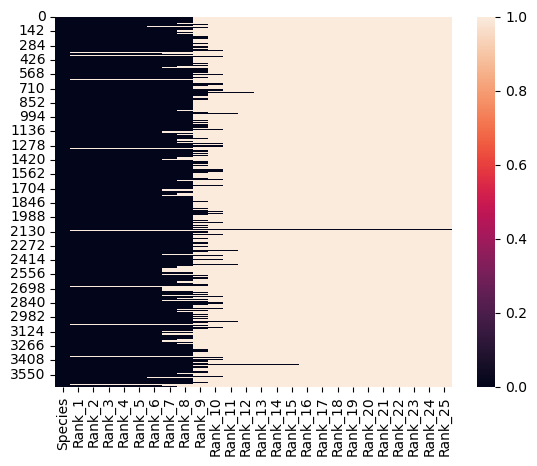

In [22]:
species_df = pd.read_csv("./data/metasub/species_lineages.csv")
species_df = species_df.dropna(axis=1,how='all')
sns.heatmap(species_df.isna())

In [11]:
tax_df = pd.read_csv("./data/metasub/tax_metasub_data.csv")
tax_df.head()

,latitude,longitude,continent,city,Acanthamoeba polyphaga mimivirus,Acaryochloris marina,Acetoanaerobium sticklandii,Acetobacter aceti,Acetobacter pasteurianus,Acetobacter persici,...,Rank_6_unclassified Verrucomicrobiota,Rank_6_Roufvirus,Rank_6_Mardecavirus,Rank_6_Woeseiales,Rank_6_Dibbivirus,Rank_6_Klementvirus,Rank_6_Eisenstarkvirus,Rank_6_unclassified Cyanobacteriota,Rank_6_unclassified Gammaproteobacteria,Rank_6_Crassvirales
0,-37.78333,175.28333,oceania,hamilton,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
1,-37.78333,175.28333,oceania,hamilton,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00001,0.0
2,-37.78333,175.28333,oceania,hamilton,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00002,0.0
3,-37.78333,175.28333,oceania,hamilton,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00002,0.0
4,-37.78333,175.28333,oceania,hamilton,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
